In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
para = 'emoid'
subidsRest = [_id for _id in meta if para in meta[_id] and int(meta[_id][para]) not in [180]] # 180, 220,233,274,284,472

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', para, meta[subid][para]) for subid in subidsRest]

print('Loading complete')
print(len(rest_ts))

Loading complete
678


In [30]:
import numpy as np
import torch
import math

nRoi = 264
nt = rest_ts[0].shape[1]-1
alpha = 5

subStartIdx = 0
subEndIdx = len(rest_ts)

rest_ts_slice = rest_ts[subStartIdx:subEndIdx]
rest_ts_t_A = [torch.from_numpy(np.concatenate([ts.T[:-1], alpha*np.eye(nRoi)]))
               .float().cuda() for ts in rest_ts_slice]
# rest_ts_t_A = [torch.from_numpy(ts.T[0:-1]).float().cuda() for ts in rest_ts_slice]
rest_ts_t_B = [torch.from_numpy(ts.T[:-1]).float().cuda() for ts in rest_ts_slice]
w = (subEndIdx-subStartIdx)*[torch.zeros(nRoi,nRoi).cuda()]

prevErr = math.inf
for epoch in range(20):
    wMean = torch.mean(torch.stack(w),axis=0)
    err = 0
    for i in range(subEndIdx-subStartIdx):
        A = rest_ts_t_A[i]
#         B = rest_ts_t_B[i]
        B = torch.cat([rest_ts_t_B[i], wMean])
        w[i],_,_,_ = torch.linalg.lstsq(A,B)
        err += torch.sum(torch.abs(A@w[i]-B))
    print(f'Finished {epoch} error={err}')
    if err >= prevErr:
        break
    prevErr = err
    
print('Complete')

Finished 0 error=2607381.75
Finished 1 error=2514137.75
Finished 2 error=2505411.0
Finished 3 error=2504264.5
Finished 4 error=2504086.5
Finished 5 error=2504057.25
Finished 6 error=2504053.5
Finished 7 error=2504053.25
Finished 8 error=2504053.25
Complete


In [31]:
wMean = torch.mean(torch.stack(w),axis=0)
print(wMean)

tensor([[0.0453, 0.0230, 0.0042,  ..., 0.0058, 0.0006, 0.0018],
        [0.0230, 0.0453, 0.0041,  ..., 0.0055, 0.0007, 0.0021],
        [0.0042, 0.0041, 0.0375,  ..., 0.0020, 0.0020, 0.0021],
        ...,
        [0.0058, 0.0055, 0.0020,  ..., 0.0431, 0.0025, 0.0024],
        [0.0006, 0.0007, 0.0020,  ..., 0.0025, 0.0397, 0.0078],
        [0.0018, 0.0021, 0.0021,  ..., 0.0024, 0.0078, 0.0321]],
       device='cuda:0')


In [311]:
print(w[0]-w[1])

tensor([[ 0.0493,  0.0702,  0.0210,  ...,  0.0091, -0.0496, -0.0273],
        [ 0.0218,  0.0394,  0.0399,  ...,  0.0413,  0.0260,  0.0117],
        [ 0.0051, -0.0158, -0.0005,  ..., -0.0084, -0.0088, -0.0442],
        ...,
        [ 0.0031, -0.0085, -0.0203,  ...,  0.0172,  0.0024, -0.0049],
        [ 0.0320,  0.0051, -0.0091,  ...,  0.0137, -0.0285,  0.0309],
        [ 0.0103,  0.0015,  0.0036,  ...,  0.0208,  0.0341, -0.0074]],
       device='cuda:0')


In [276]:
torch.sum(torch.abs(wMean-wMean.T))

tensor(935.1218, device='cuda:0')

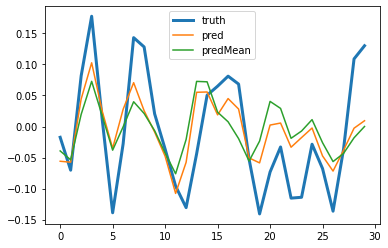

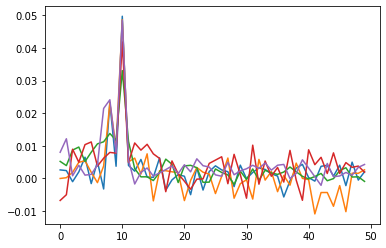

In [32]:
import matplotlib.pyplot as plt

subIdx = 0

pred = rest_ts_t_A[subIdx]@w[subIdx]
pred = pred.detach().cpu().numpy()
truth = rest_ts_t_B[subIdx].detach().cpu().numpy()

wMean = torch.mean(torch.stack(w),axis=0)
predMean = rest_ts_t_A[subIdx]@wMean
predMean = predMean.detach().cpu().numpy()

plt.plot(truth[50:80,0], label='truth', linewidth=3)
plt.plot(pred[50:80,0], label='pred')
plt.plot(predMean[50:80,0], label='predMean')
plt.legend()
plt.show()

wPlot = np.zeros([5,50])

for i in range(wPlot.shape[0]):
    wPlot[i] = w[i][:50,10].detach().cpu().numpy()

plt.plot(wPlot.T)
plt.show()

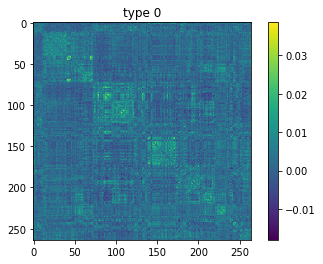

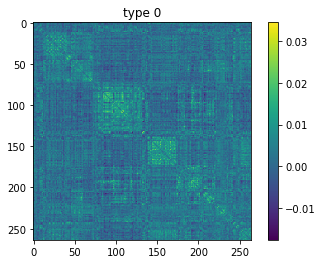

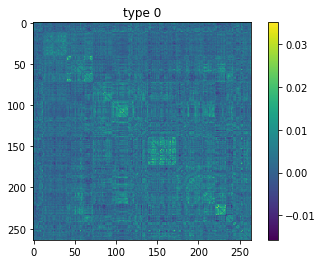

In [33]:
import matplotlib.colors as colors

def showMasked(w, title):
    plt.imshow((w*(torch.ones(nRoi,nRoi)-torch.eye(nRoi)).cuda()).detach().cpu().numpy())
    plt.colorbar()
    plt.title(title)
    plt.show()

showMasked(w[0], 'type 0')
showMasked(w[1], 'type 0')
showMasked(w[10], 'type 0')
# showMasked(w[800], 'type 0')
# showMasked(w[250], 'type 1')
# showMasked(w[300], 'type 1')
# showMasked(w[400], 'type 1')

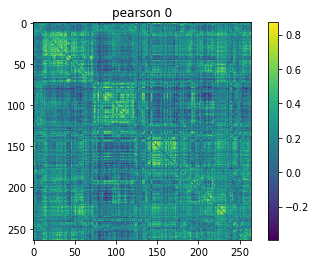

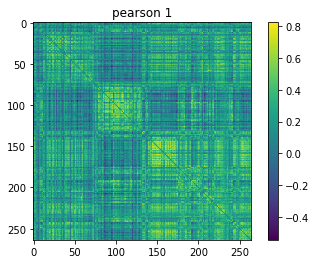

In [40]:
showMasked(ps_t[0].reshape(264,264), 'pearson 0')
showMasked(ps_t[1].reshape(264,264), 'pearson 1')

In [9]:
ps_t = torch.stack([torch.from_numpy(np.corrcoef(ts).flatten()).float().cuda() 
                    for ts in rest_ts[subStartIdx:subEndIdx]])

print('Complete')

Complete


In [36]:
ps_t2 = ps_t-torch.mean(ps_t)

In [37]:
nTrials = 50
cc = np.zeros(nTrials)
pc = np.zeros(nTrials)

nAges = subEndIdx-subStartIdx
A = torch.zeros(nAges,264*264).cuda()
B = torch.zeros(nAges).cuda()

iRest = 0
iAge = 0

for sub in meta.values():
    if para in sub and int(sub[para]) not in [180]: # 180, 220,233,274,284,472
        if iRest >= subStartIdx and iRest < subEndIdx:
            A[iAge] = w[iAge].reshape(-1)
            B[iAge] = sub['meta']['AgeInMonths']/12
            iAge += 1
        iRest += 1

for i in range(nTrials):
    perm = torch.randperm(A.shape[0])
    trainIdx = perm[:600]
    testIdx = perm[600:]
    
    Atrain = A[trainIdx]
    Atest = A[testIdx]

    Btrain = B[trainIdx]
    Btest = B[testIdx]

    wAge,trainErr,_,_ = torch.linalg.lstsq(Atrain,Btrain)    

    agePred = Atest@wAge
    cc[i] = torch.mean(torch.abs(agePred-Btest)).detach().cpu().numpy()
    
    Aps_train = ps_t2[trainIdx]
    Aps_test = ps_t2[testIdx]

    wAge,_,_,_ = torch.linalg.lstsq(Aps_train,Btrain)

    agePred = Aps_test@wAge
    pc[i] = torch.mean(torch.abs(agePred-Btest)).detach().cpu().numpy()
    
    if i%10 == 0 or i == nTrials:
        print(f'Finished {i}')
        
print('Complete')

print(np.mean(cc))
print(np.mean(pc))

print(np.std(cc))
print(np.std(pc))

Finished 0
Finished 10
Finished 20
Finished 30
Finished 40
Complete
1.666003348827362
1.7960643410682677
0.13781702271956398
0.15265599025410848


In [375]:
def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj1 = subjects[i]
        subj1 -= np.mean(subj1, axis=1, keepdims=True)@np.ones([1,subj1.shape[1]])
        subj1 /= np.std(subj1, axis=1, keepdims=True)@np.ones([1,subj1.shape[1]])
        if np.sum(np.isnan(subj1)) > 0:
            print(i)
        if np.sum(np.isinf(subj1)) > 0:
            print(i)

normalizeSubjects(rest_ts)

In [161]:
for subj in [220,233,274,284,472]:
    print(f'subj {subj}')
    for i in range(264):
        if np.sum(rest_ts[subj][i,:]) == 0:
            print(f'\t{i}')

subj 220
	55
	105
	115
	197
	230
subj 233
	13
	36
	42
	68
	152
	165
	166
	217
subj 274
	4
	143
	206
subj 284
	34
	54
	112
	132
	230
	259
subj 472
	37
	81
	89
	103
	130
	136
	171
	172
	176
	182
	196
	235
	241


In [146]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)

/tmp/ipykernel_1423435/2645374586.py:7: RuntimeWarning: invalid value encountered in true_divide
  subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])


169


In [152]:
for key in meta:
    if 'emoid' in meta[key]:
        ts = loadSeries('../../PNC', para, meta[key][para])
        if np.sum(np.isnan(np.corrcoef(ts))) > 0:
            print(meta[key][para])

180


In [242]:
a = torch.ones(10,10).cuda()
print(a)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')
